In [67]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

pl.Config(tbl_rows=20, tbl_cols=1000)

df = pl.read_csv("../Data/Titanic/train.csv")

In [68]:
df.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""
4,1,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,"""Allen, Mr. William Henry""","""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


In [69]:
def standardize(column):
    return (column - column.mean()) / column.std()

# Cleaning columns
df = df.with_columns(
    [
        pl.when(pl.col("Sex")=="male").then(pl.lit(1)).otherwise(pl.lit(0)).alias("Sex"),
        pl.col("Age").fill_null(pl.col("Age").median().over("Pclass")),
    ]
)

# Feature engineering
df = df.with_columns(
    [
        pl.col("Name").str.extract(r", (.*?)\.").alias("Title"),
        pl.when(pl.col("Cabin").is_not_null()).then(1).otherwise(0).alias("HasCabinRegistered"),
        (pl.col("SibSp") + pl.col("Parch") + 1).alias("FamilySize"),
        pl.col("Cabin").str.extract("^([A-Za-z]){1}").alias("Deck"),
        pl.col("Cabin").str.extract("^.([0-9]+)").cast(pl.Int64).alias("RoomNumber"),
    ]
)

# Bin Features with quantiles
df = df.with_columns(
    [
        pl.when(pl.col("Age") < pl.col("Age").quantile(.25)).then(pl.lit(1))
        .when(pl.col("Age") < pl.col("Age").quantile(.50)).then(pl.lit(2))
        .when(pl.col("Age") < pl.col("Age").quantile(.75)).then(pl.lit(3))
        .otherwise(4)
        .alias("AgeGroupQuantiles"),
        pl.when(pl.col("Fare") < pl.col("Fare").quantile(.25)).then(1)
        .when(pl.col("Fare") < pl.col("Fare").quantile(.50)).then(2)
        .when(pl.col("Fare") < pl.col("Fare").quantile(.75)).then(3)
        .otherwise(4).alias("FareGroupQuantiles")
    ]
)

# Bin Featuers with domain knowledge

# Second order Feature engineering
df = df.with_columns(
        pl.when(pl.col("Title").is_in(["Jonkheer", "the Countess", "Lady", "Sir", "Don", "Master", "Major", "Capt", "Rev", "Dr", "Col"]))
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .alias("HasTitle"),
)

# Dummy Features
df = df.to_dummies(
    [
        "Embarked", 
        "Deck"
    ],
    drop_first=True
)

# Drop Features
df = df.drop(
    "Name",
    "Ticket",
    "PassengerId",
    "Embarked_null",
    "Cabin",
    "RoomNumber"
)

# Third order Feature engineering
# df = df.with_columns(

# )

df.head()

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Title,HasCabinRegistered,FamilySize,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,AgeGroupQuantiles,FareGroupQuantiles,HasTitle
i64,i64,i32,f64,i64,i64,f64,u8,u8,str,i32,i64,u8,u8,u8,u8,u8,u8,u8,u8,i32,i32,i32
0,3,1,22.0,1,0,7.25,0,0,"""Mr""",0,2,0,0,0,0,0,0,0,0,2,1,0
1,1,0,38.0,1,0,71.2833,1,0,"""Mrs""",1,2,0,0,1,0,0,0,0,0,4,4,0
1,3,0,26.0,0,0,7.925,0,0,"""Miss""",0,1,0,0,0,0,0,0,0,0,3,2,0
1,1,0,35.0,1,0,53.1,0,0,"""Mrs""",1,2,0,0,1,0,0,0,0,0,3,4,0
0,3,1,35.0,0,0,8.05,0,0,"""Mr""",0,1,0,0,0,0,0,0,0,0,3,2,0


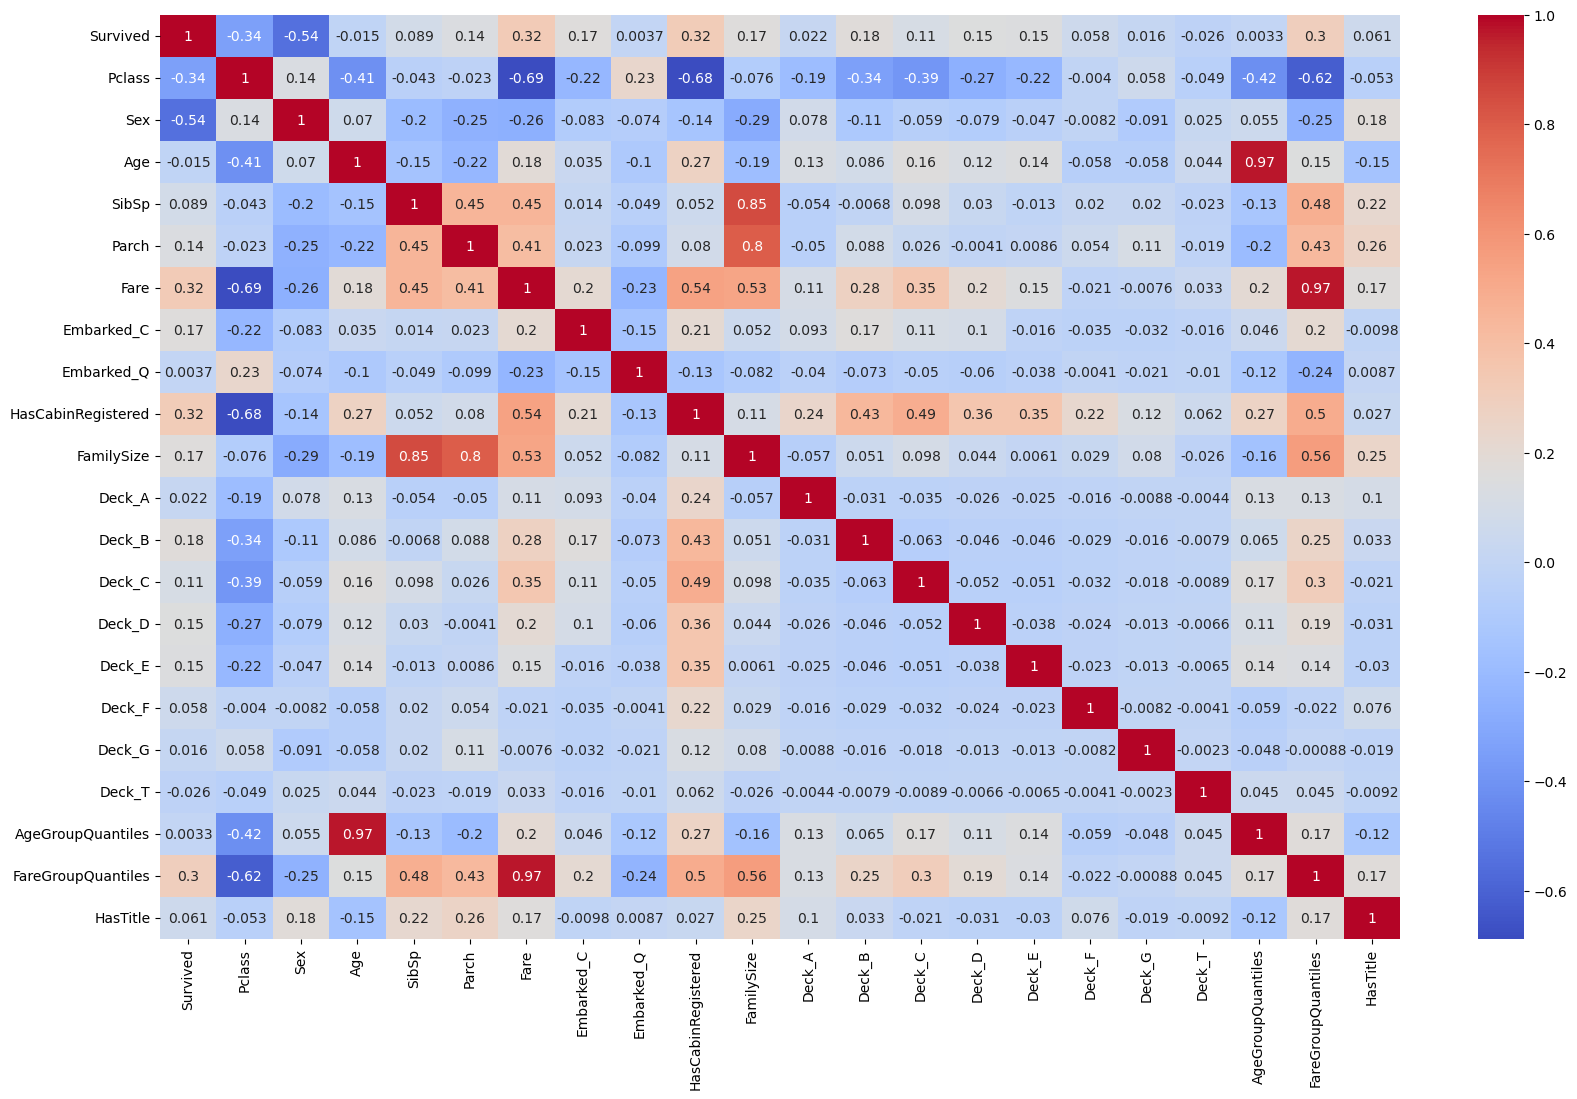

In [70]:
# df.write_csv("../Data/advancedDataframe.csv")

def heatmap(df, figsize=(20, 12), method="spearman"):
    corr_matrix = df.select(
        pl.col(pl.selectors.NUMERIC_DTYPES)
    ).to_pandas().corr(method=method)

    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

heatmap(df)


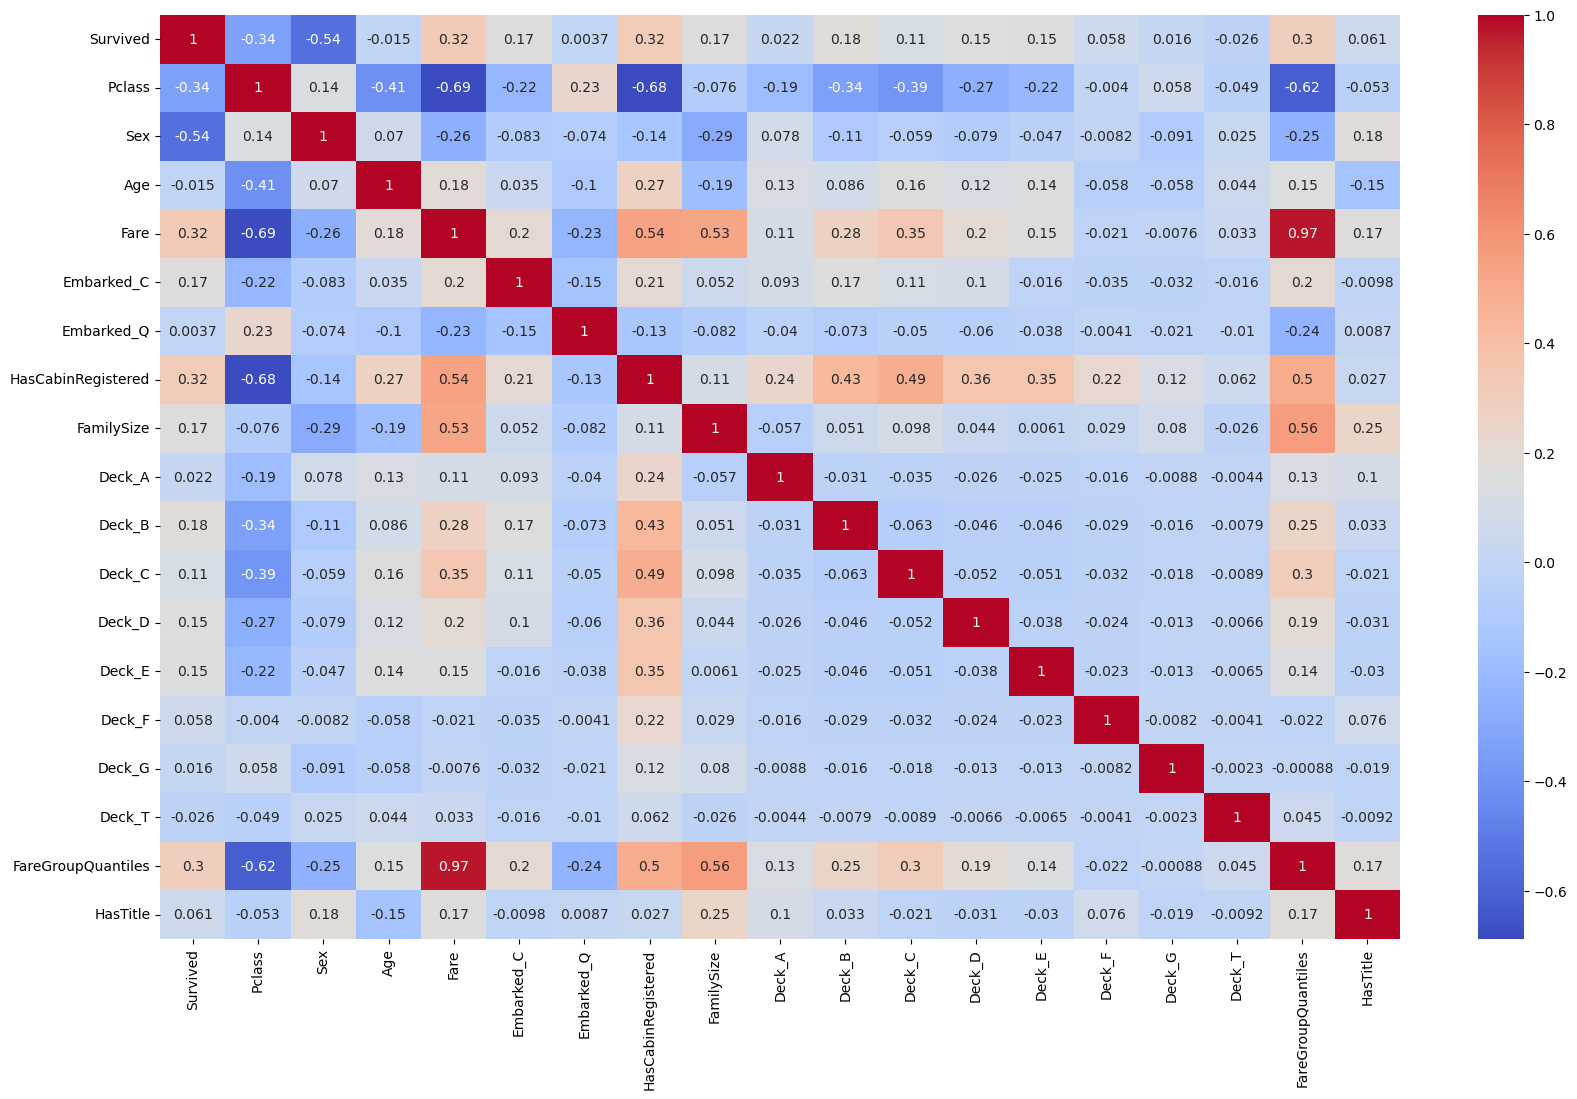

In [71]:
df = df.drop("SibSp", "Parch", "AgeGroupQuantiles")

heatmap(df)

In [73]:
df = df.with_columns(
    (pl.col("Fare") / pl.col("FamilySize")).alias("FarePerPerson")
)

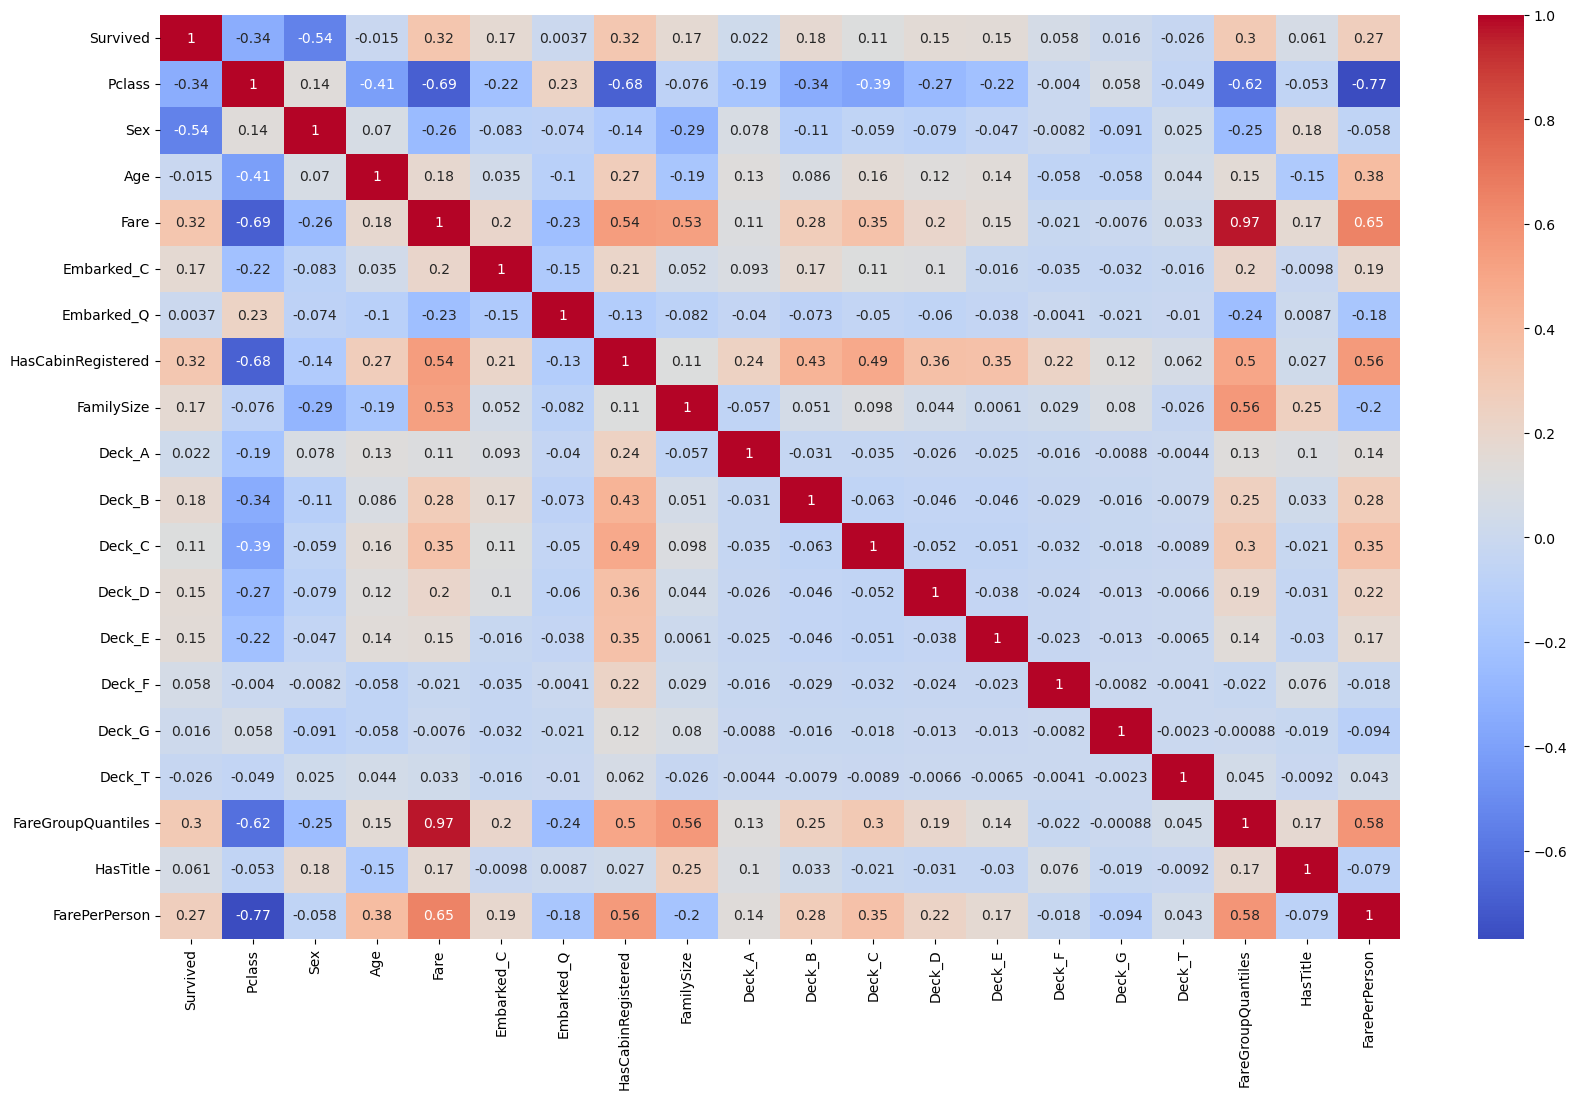

In [74]:
heatmap(df)